In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy 
from scipy.special import legendre
from scipy.stats import unitary_group

In [76]:
class QubitControl(object):
    """A class for simulating single-qubit control on quantum hardware.
    The finest time-resolution dt will be rescaled to 1 in the numerical simulation.
    Parametrization for pulses: Legendre or NN.
    
    The derivatives are computed by our method.
    Args:
        n_basis: number of Fourier basis.
    """
    def __init__(self, dt=0.22, eps=32.901, Amax=0.955, freq=2*np.pi*5.236, duration=96,
                 n_basis=5, basis='Legendre', n_epoch=200, lr=1e-2, 
                 is_sample_discrete=False, is_noisy=False):
        self.dt = dt
        self.raw_eps = eps
        self.raw_Amax = Amax
        self.raw_freq = freq
        self.duration = duration
        
        self.eps = eps * dt
        self.Amax = Amax * dt
        self.w = freq * dt
        
        self.n_basis = n_basis
        self.log_dir = "./logs/"
        self.log_name = basis
        self.basis = basis
        self.n_epoch = n_epoch
        self.lr = lr
        self.is_sample_discrete = is_sample_discrete
        self.is_noisy = is_noisy

        if basis == 'Legendre':
            self.legendre_ps = [legendre(j) for j in range(self.n_basis)]
        
        
        
    def generate_f(self, vv):
        """Generate the function f(t)
        Args:
            vv: parameters for the ansatz
        Returns:
            _f: function f(t).
        """
        
        def _f(t, args):
            # t ranges from [0, duration]
            u = 0
            for j in range(self.n_basis):
                u += vv[j] * legendre(j)(2 * t / self.duration - 1)
            
            return 2 * scipy.special.expit(u) - 1

        return _f
    
    def full_pulse(self, vv):
        """Generate the full driving pulse for H1 = X
        Args:
            vv: parameters for the ansatz
        Returns:
            _D: driving pulse D(t)
        """
        
        def _D(t, args):
            # t ranges from [0, duration]
            u = 0
            for j in range(self.n_basis):
                u += vv[j] * legendre(j)(2 * t / self.duration - 1)
            
            return np.cos(self.w * t) * (2 * scipy.special.expit(u) - 1)

        return _D
    
    
    def get_integrand(self, M, initial_state, s):
        
        integrand = np.zeros(self.vv.shape)
        
        # compute dDdv
        #param = torch.clone(self.vv)
        #param.requires_grad = True
        sgm = torch.nn.Sigmoid()
        legendre_ps = [self.vv[j] * legendre(j)(2 * s / self.duration - 1) for j in range(self.n_basis)]
        Ds = np.cos(self.w * s) * (2 * sgm(sum(legendre_ps)) - 1)
        Ds.backward()
        dDdv = self.vv.grad.detach().numpy()

        
        # compute ps = ps_m - ps_p
        H0 = np.array(
            [[0, 0], 
            [0, self.eps]])
        H0 = qp.Qobj(H0)
        
        X = np.array(
            [[0, 1], 
            [1, 0]])
        X = qp.Qobj(X)
        H = [H0]
        H.append([X, self.full_pulse(self.vv.detach().numpy())])
        
        t0s = np.linspace(0, s, 10)
        result = qp.mesolve(H, initial_state, t0s)
        phi = result.states[-1]
        
        r = 1 / 2
        gate_p = (qp.qeye(2) + r * 1.j * X) / np.sqrt(1. + r**2)
        gate_m = (qp.qeye(2) - r * 1.j * X) / np.sqrt(1. + r**2)
            
        ts1 = np.linspace(s, self.duration, 10)
        result = qp.mesolve(H, gate_p * phi, ts1)
        ket_p = result.states[-1]
        ps_p = M.matrix_element(ket_p, ket_p)
        if self.is_noisy:
            ps_p += np.random.normal(scale=np.abs(ps_p.real) / 5)
            
        result = qp.mesolve(H, gate_m * phi, ts1)
        ket_m = result.states[-1]
        ps_m = M.matrix_element(ket_m, ket_m)
        if self.is_noisy:
            ps_m += np.random.normal(scale=np.abs(ps_m.real) / 5)

        ps = ((1 + r**2) / 2 / r * (ps_m - ps_p)).real
        
        return ps * dDdv
        


    def compute_energy_grad_MC(self, M, initial_state, num_sample):
        """Compute the gradient of engergy function <psi(T)|M|psi(T)>, T = duration
        Args:
            vv0: current parameters
            M: A Hermitian matrix.
            initial_state: initial_state.
            num_sample = # of MC samples in [0,T]
        Returns:
            grad_coeff: (estimated) gradients of the parameters vv.
        """
        if self.is_sample_discrete == False:
            sample_time = np.random.uniform(0, self.duration, size=num_sample)
        else: 
            sample_time = 1 + np.random.randint(0, self.duration-1, size=num_sample)

        grad = np.zeros(self.n_basis)
        for s in sample_time: 
            grad += self.get_integrand(M, initial_state, s)
        
        return torch.from_numpy(self.duration * grad / num_sample)
    
    def compute_energy(self, M, initial_state,):
        H0 = np.array(
            [[0, 0], 
            [0, self.eps]])
        H0 = qp.Qobj(H0)
        
        X = np.array(
            [[0, 1], 
            [1, 0]])
        X = qp.Qobj(X)
        H = [H0]
        H.append([X, self.full_pulse(self.vv.detach().numpy())])
        
        tarray = np.linspace(0, self.duration, 10)
        result = qp.mesolve(H, initial_state, tarray)
        psi_T = result.states[-1]
        
        return np.real(M.matrix_element(psi_T, psi_T))
    
    
    def save_plot(self, plot_name):
        return
        ts = np.linspace(0, 1, self.n_step) 
        fs = [self.generate_u(i, self.spectral_coeff.detach().numpy()) for i in range(self.n_Hs)]
        np_us = np.array([[f(x, None) for f in fs] for x in ts])
        plt.clf()
        for j in range(len(fs)):
            plt.plot(np_us[:, j], label='{} u_{}'.format(self.log_name,  j))

        plt.legend(loc="upper right")
        plt.savefig("{}{}_{}.png".format(self.log_dir, self.log_name, plot_name))

        
        
    def train_energy(self, M, initial_state, vv0, num_sample):
        """Train the sepctral coefficients to minimize energy minimization.
        Args:
            M: A Hermitian matrix.
            initial_state: initial_state.
            vv0: initial guess of the parameters
        Returns:
            vv_final: optimized parameters
        """
        if len(vv0) != self.n_basis:
            print("The length of initial guess must be the same as n_basis!")
        
        self.vv = torch.tensor(vv0, requires_grad=True)
        
        w_l2 = 0
        lr = self.lr
        optimizer = torch.optim.Adam([self.vv], lr=lr)

        self.losses_energy = []
        for epoch in range(1, self.n_epoch + 1):
            if epoch % 20 == 0:
                self.save_plot(epoch)
            
            loss_energy = self.compute_energy(M, initial_state)
            if self.is_noisy:
                loss_energy += np.random.normal(scale=np.abs(loss_energy) / 5)
            loss_l2 = ((self.vv**2).mean(0) * torch.tensor(
                [i**2 for i in range(self.n_basis)])).mean() * w_l2
            loss = loss_energy + loss_l2
            optimizer.zero_grad()
            loss_l2.backward()
            grad_vv = self.compute_energy_grad_MC(M, initial_state, num_sample)
            self.vv.grad = grad_vv
            optimizer.step()

            print("epoch: {:04d}, loss: {:.4f}, loss_energy: {:.4f}".format(
                epoch, 
                loss, 
                loss_energy
            ))
            self.losses_energy.append(loss_energy.real)
            #self.final_state = final_state
            
            
        return self.vv
    
    
    def model_qubit(self, vv0, num_sample, method):
        
        I = np.array(
            [[1, 0], 
            [0, 1]])
        X = np.array(
            [[0, 1], 
            [1, 0]])
        Z = np.array(
            [[1, 0], 
            [0, -1]])
        
        M = qp.Qobj(0.5 * (I + Z))
        psi0 = qp.basis(2, 0)
        
        if method == 'plain':
            self.train_energy(M, psi0, vv0, num_sample)
        elif method == 'rwa':
            self.train_energy(M, psi0, vv0, num_sample)
        else:
            print("Method must be plain or rwa.")

        return
    
    def plot_integrand(self, i, vv0):
        if i > self.n_basis:
            print("Index i is no more than n_basis.")
        
        self.vv = torch.tensor(vv0, requires_grad=True)
        
        I = np.array(
            [[1, 0], 
            [0, 1]])
        X = np.array(
            [[0, 1], 
            [1, 0]])
        Z = np.array(
            [[1, 0], 
            [0, -1]])
        
        M = qp.Qobj(0.5 * (I + Z))
        psi0 = qp.basis(2, 0)
        integrand = np.zeros(self.duration-2);
        
        for k in range(self.duration-2):
            s = k+1
            g = self.get_integrand(M, psi0, s)
            integrand[k] = g[i-1]
            display(k)
        
        return integrand
    

In [47]:
if __name__ == '__main__':
    model = QubitControl(basis='Legendre', n_basis=5 , dt=0.22, duration=96, n_epoch=50, lr = 5e-3)
    vv0 = np.random.rand(model.n_basis)
    num_sample = 1
    g = model.model_qubit(vv0, num_sample, 'plain')
    loss0 = model.losses_energy

epoch: 0001, loss: 0.3998, loss_energy: 0.3998
epoch: 0002, loss: 0.2951, loss_energy: 0.2951
epoch: 0003, loss: 0.2225, loss_energy: 0.2225
epoch: 0004, loss: 0.1666, loss_energy: 0.1666
epoch: 0005, loss: 0.1182, loss_energy: 0.1182
epoch: 0006, loss: 0.0749, loss_energy: 0.0749
epoch: 0007, loss: 0.0371, loss_energy: 0.0371
epoch: 0008, loss: 0.0113, loss_energy: 0.0113
epoch: 0009, loss: 0.0009, loss_energy: 0.0009
epoch: 0010, loss: 0.0017, loss_energy: 0.0017
epoch: 0011, loss: 0.0105, loss_energy: 0.0105
epoch: 0012, loss: 0.0215, loss_energy: 0.0215
epoch: 0013, loss: 0.0347, loss_energy: 0.0347
epoch: 0014, loss: 0.0453, loss_energy: 0.0453
epoch: 0015, loss: 0.0485, loss_energy: 0.0485
epoch: 0016, loss: 0.0446, loss_energy: 0.0446
epoch: 0017, loss: 0.0367, loss_energy: 0.0367
epoch: 0018, loss: 0.0287, loss_energy: 0.0287
epoch: 0019, loss: 0.0216, loss_energy: 0.0216
epoch: 0020, loss: 0.0159, loss_energy: 0.0159
epoch: 0021, loss: 0.0114, loss_energy: 0.0114
epoch: 0022, 

In [68]:
vv0

array([0.73765115, 0.30880234, 0.51121464, 0.12164895, 0.20280159])

In [77]:
if __name__ == '__main__':
    model = QubitControl(basis='Legendre', n_basis=5 , dt=0.22, duration=50, n_epoch=50, lr = 5e-3)
    integrand = model.plot_integrand(1, vv0)

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

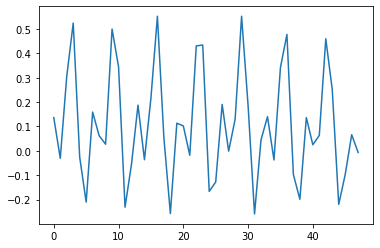

In [78]:
plt.plot(integrand)

In [79]:
if __name__ == '__main__':
    #model = QubitControl(basis='Legendre', n_basis=5 , dt=0.22, duration=96, n_epoch=50, lr = 5e-3)
    num_sample = 10
    g = model.model_qubit(vv0, num_sample, 'plain')
    loss1 = model.losses_energy

epoch: 0001, loss: 0.5157, loss_energy: 0.5157
epoch: 0002, loss: 0.4666, loss_energy: 0.4666
epoch: 0003, loss: 0.4190, loss_energy: 0.4190
epoch: 0004, loss: 0.3755, loss_energy: 0.3755
epoch: 0005, loss: 0.3311, loss_energy: 0.3311
epoch: 0006, loss: 0.2871, loss_energy: 0.2871
epoch: 0007, loss: 0.2457, loss_energy: 0.2457
epoch: 0008, loss: 0.2047, loss_energy: 0.2047
epoch: 0009, loss: 0.1664, loss_energy: 0.1664
epoch: 0010, loss: 0.1310, loss_energy: 0.1310
epoch: 0011, loss: 0.0993, loss_energy: 0.0993
epoch: 0012, loss: 0.0720, loss_energy: 0.0720
epoch: 0013, loss: 0.0488, loss_energy: 0.0488
epoch: 0014, loss: 0.0304, loss_energy: 0.0304
epoch: 0015, loss: 0.0165, loss_energy: 0.0165
epoch: 0016, loss: 0.0073, loss_energy: 0.0073
epoch: 0017, loss: 0.0020, loss_energy: 0.0020
epoch: 0018, loss: 0.0001, loss_energy: 0.0001
epoch: 0019, loss: 0.0008, loss_energy: 0.0008
epoch: 0020, loss: 0.0035, loss_energy: 0.0035
epoch: 0021, loss: 0.0066, loss_energy: 0.0066
epoch: 0022, 

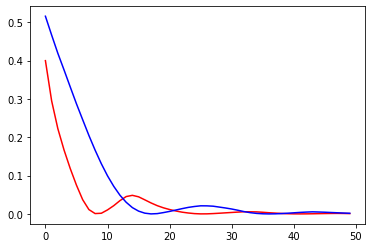

In [80]:
plt.plot(loss0,'r-')
plt.plot(loss1,'b-')
plt.show()